In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
import numpy as np
from scipy import stats
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
exp10_flow_01_df = pd.read_csv('./csv/exp10_flow_01.csv', sep=',')

In [3]:
exp10_flow_02_df = pd.read_csv('./csv/exp10_flow_02.csv', sep=',')

In [4]:
exp10_flow_03_df = pd.read_csv('./csv/exp10_flow_03.csv', sep=',')

In [5]:
exp10_waight_01_df = pd.read_csv('./csv/exp10_waight_01.csv', sep=',')

In [6]:
exp10_waight_02_df = pd.read_csv('./csv/exp10_waight_02.csv', sep=',')

In [7]:
exp10_waight_03_df = pd.read_csv('./csv/exp10_waight_03.csv', sep=',')

In [8]:
exp10_waight_01_df.columns

Index(['datetime', 'weight_kg'], dtype='object')

In [9]:
# Функция для усреднения данных за секунду
def average_per_second(df, time_column, value_column):
    # Приведение временной метки к секундной точности
    df[time_column] = pd.to_datetime(df[time_column])
    df['second'] = df[time_column].dt.floor('S')  # Округление до секунд
    
    # Группировка по секундам и усреднение
    df_avg = df.groupby('second')[value_column].mean().reset_index()
    df_avg.rename(columns={'second': 'Timestamp', value_column: f'{value_column}_avg'}, inplace=True)
    return df_avg

In [10]:
# Усреднение данных для расходомеров
flow_01_avg = average_per_second(exp10_flow_01_df, 'Timestamp', 'FT_F01_Hz')
flow_02_avg = average_per_second(exp10_flow_02_df, 'Timestamp', 'FT_F01_Hz')
flow_03_avg = average_per_second(exp10_flow_03_df, 'Timestamp', 'FT_L01_Hz')

/tmp/ipykernel_318330/3920587757.py:5: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  df['second'] = df[time_column].dt.floor('S')  # Округление до секунд
/tmp/ipykernel_318330/3920587757.py:5: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  df['second'] = df[time_column].dt.floor('S')  # Округление до секунд
/tmp/ipykernel_318330/3920587757.py:5: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  df['second'] = df[time_column].dt.floor('S')  # Округление до секунд


In [11]:
# Усреднение данных для массы воды
weight_01_avg = average_per_second(exp10_waight_01_df, 'datetime', 'weight_kg')
weight_02_avg = average_per_second(exp10_waight_02_df, 'datetime', 'weight_kg')
weight_03_avg = average_per_second(exp10_waight_03_df, 'datetime', 'weight_kg')

/tmp/ipykernel_318330/3920587757.py:5: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  df['second'] = df[time_column].dt.floor('S')  # Округление до секунд
/tmp/ipykernel_318330/3920587757.py:5: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  df['second'] = df[time_column].dt.floor('S')  # Округление до секунд
/tmp/ipykernel_318330/3920587757.py:5: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  df['second'] = df[time_column].dt.floor('S')  # Округление до секунд


In [12]:
# Функция для объединения данных с учётом временной задержки
def merge_with_delay(flow_df, weight_df, flow_column, weight_column):
    # Приведение временных меток к datetime
    flow_df['Timestamp'] = pd.to_datetime(flow_df['Timestamp'])
    weight_df['Timestamp'] = pd.to_datetime(weight_df['Timestamp'])
      
    # Объединение данных с использованием 'outer'
    merged_df = pd.merge(flow_df, weight_df, on='Timestamp', how='outer')
    
    # Заполнение пропущенных значений
    # Для расходомера: пропущенные значения заменяем на 0
    merged_df[flow_column] = merged_df[flow_column].fillna(0)
    
    # Для массы: пропущенные значения заполняем ближайшими по времени
    merged_df[weight_column] = merged_df[weight_column].fillna(method='ffill').fillna(method='bfill')
    
    return merged_df

In [13]:
# Применение функции для каждого набора данных
merged_01 = merge_with_delay(flow_01_avg, weight_01_avg, 'FT_F01_Hz_avg', 'weight_kg_avg')
merged_02 = merge_with_delay(flow_02_avg, weight_02_avg, 'FT_F01_Hz_avg', 'weight_kg_avg')
merged_03 = merge_with_delay(flow_03_avg, weight_03_avg, 'FT_L01_Hz_avg', 'weight_kg_avg')

/tmp/ipykernel_318330/2634076839.py:15: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_df[weight_column] = merged_df[weight_column].fillna(method='ffill').fillna(method='bfill')
/tmp/ipykernel_318330/2634076839.py:15: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_df[weight_column] = merged_df[weight_column].fillna(method='ffill').fillna(method='bfill')
/tmp/ipykernel_318330/2634076839.py:15: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_df[weight_column] = merged_df[weight_column].fillna(method='ffill').fillna(method='bfill')


In [14]:
# Функция для расчёта расхода воды
def calculate_flow_rate(df, weight_column, flow_column):
    # Вычисление разницы массы (приращение массы)
    df['mass_diff'] = df[weight_column].diff()
    
    # Вычисление разницы времени в секундах
    df['time_diff'] = df['Timestamp'].diff().dt.total_seconds()
    
    # Расчёт расхода воды (масса в кг/с)
    df['flow_rate_kg_per_s'] = df['mass_diff'] / df['time_diff']
    
    # Удаление строк с NaN (первая строка, где нет предыдущего значения)
    df = df.dropna(subset=['flow_rate_kg_per_s'])
    
    return df

In [15]:
# Применение функции для каждого объединённого датафрейма
merged_01 = calculate_flow_rate(merged_01, 'weight_kg_avg', 'FT_F01_Hz_avg')
merged_02 = calculate_flow_rate(merged_02, 'weight_kg_avg', 'FT_F01_Hz_avg')
merged_03 = calculate_flow_rate(merged_03, 'weight_kg_avg', 'FT_L01_Hz_avg')

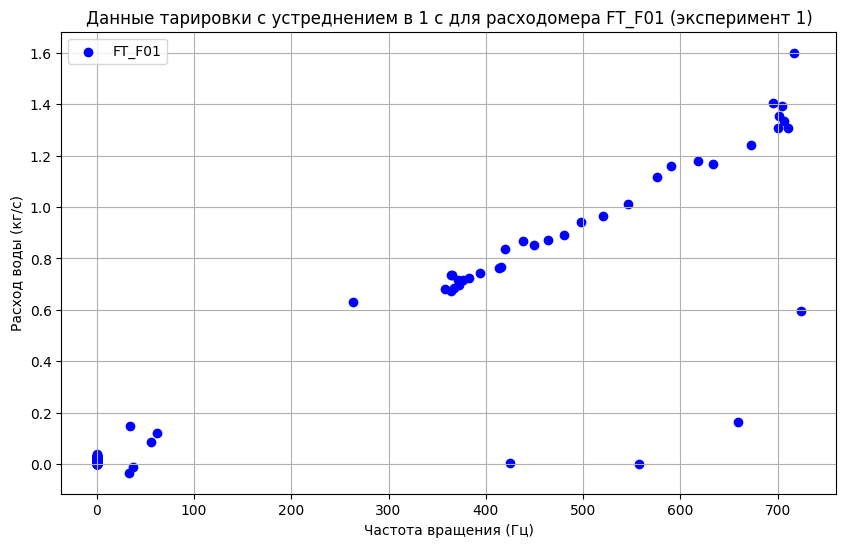

In [16]:
# Построение графика для первого расходомера первый эксперимент
plt.figure(figsize=(10, 6))
plt.scatter(merged_01['FT_F01_Hz_avg'], merged_01['flow_rate_kg_per_s'], color='blue', label='FT_F01')
plt.xlabel('Частота вращения (Гц)')
plt.ylabel('Расход воды (кг/с)')
plt.title('Данные тарировки с устреднением в 1 с для расходомера FT_F01 (эксперимент 1)')
plt.legend()
plt.grid()
plt.savefig(f'./results/fig/FT_F01_avg_01.png')
plt.show()

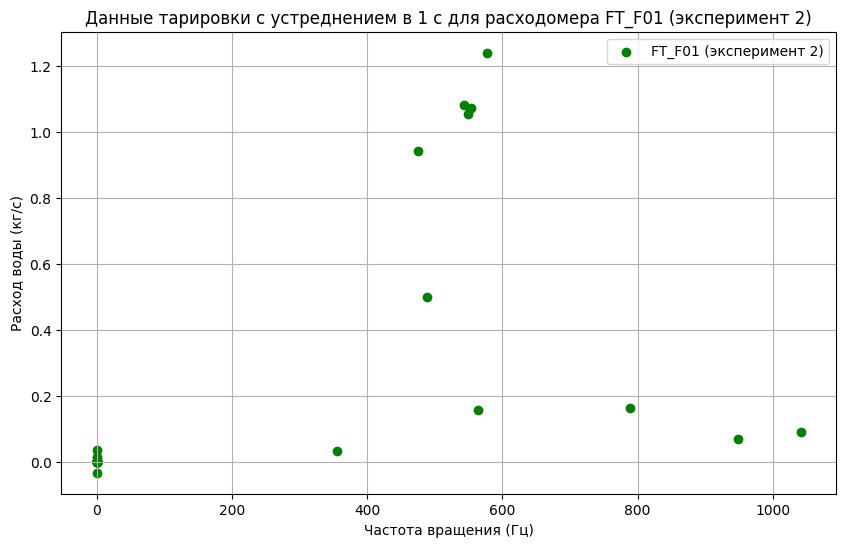

In [17]:
# Построение графика для перовго расходомера второй эксперимент
plt.figure(figsize=(10, 6))
plt.scatter(merged_02['FT_F01_Hz_avg'], merged_02['flow_rate_kg_per_s'], color='green', label='FT_F01 (эксперимент 2)')
plt.xlabel('Частота вращения (Гц)')
plt.ylabel('Расход воды (кг/с)')
plt.title('Данные тарировки с устреднением в 1 с для расходомера FT_F01 (эксперимент 2)')
plt.legend()
plt.grid()
plt.savefig(f'./results/fig/FT_F01_avg_02.png')
plt.show()

Данные второго эксперимента выглядят как мусорные, вероятно, было мало показаний и/или малый расход.

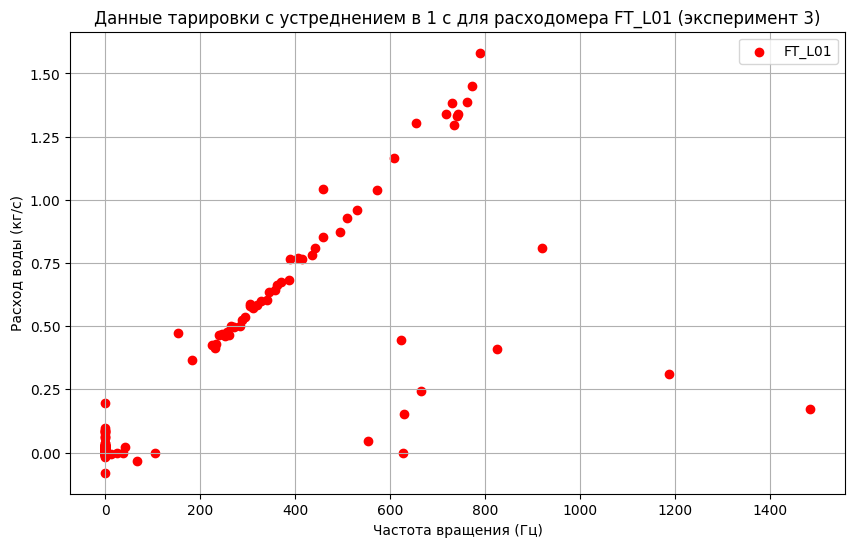

In [18]:
# Построение графика для второго расходомера
plt.figure(figsize=(10, 6))
plt.scatter(merged_03['FT_L01_Hz_avg'], merged_03['flow_rate_kg_per_s'], color='red', label='FT_L01')
plt.xlabel('Частота вращения (Гц)')
plt.ylabel('Расход воды (кг/с)')
plt.title('Данные тарировки с устреднением в 1 с для расходомера FT_L01 (эксперимент 3)')
plt.legend()
plt.grid()
plt.savefig(f'./results/fig/FT_L01_avg_03.png')
plt.show()

In [19]:
# Функция для фильтрации данных и построения новой линии регрессии
def filter_and_regress(df, flow_column, rate_column, threshold=0.2):
    # Первая линия регрессии
    X = df[flow_column].values.reshape(-1, 1)
    y = df[rate_column].values
    model = LinearRegression()
    model.fit(X, y)
    
    # Предсказанные значения
    y_pred = model.predict(X)
    
    # Вычисление отклонений (остатков)
    residuals = np.abs(y - y_pred)
    
    # Фильтрация данных: оставляем только точки с отклонением меньше threshold * y_pred
    mask = residuals <= threshold * y_pred
    filtered_df = df[mask]
    
    # Вторая линия регрессии по отфильтрованным данным
    X_filtered = filtered_df[flow_column].values.reshape(-1, 1)
    y_filtered = filtered_df[rate_column].values
    model_filtered = LinearRegression()
    model_filtered.fit(X_filtered, y_filtered)
    
    # Возвращаем модель, отфильтрованные данные и коэффициенты
    return model, model_filtered, filtered_df

In [20]:
# Отфильтруем слишком большие значения в Герцах
merged_03 = merged_03[merged_03['FT_L01_Hz_avg']<800]

In [21]:
# Применение функции для первого эксперимента
model_01, model_01_filtered, filtered_01 = filter_and_regress(
    merged_01, 'FT_F01_Hz_avg', 'flow_rate_kg_per_s', threshold=0.2
)

# Применение функции для третьего эксперимента
model_03, model_03_filtered, filtered_03 = filter_and_regress(
    merged_03, 'FT_L01_Hz_avg', 'flow_rate_kg_per_s', threshold=0.2
)

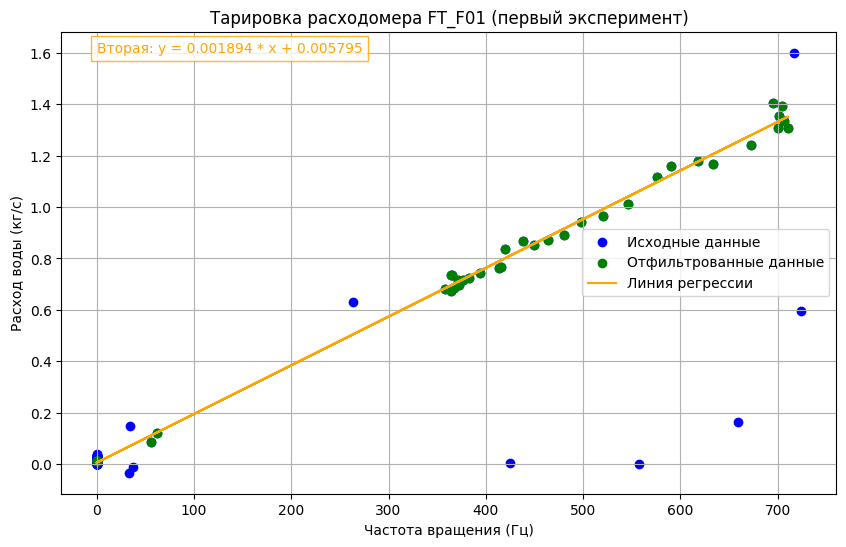

In [22]:
# Функция для добавления уравнения линии регрессии на график
def add_regression_equation(ax, model, x_range, color='red', label_prefix=''):
    slope = model.coef_[0]
    intercept = model.intercept_
    equation = f"{label_prefix}y = {slope:.6f} * x + {intercept:.6f}"
    
    # Добавляем текст на график
    ax.text(
        x_range[0],  # Начальная точка по X
        x_range[1],  # Начальная точка по Y
        equation,
        color=color,
        fontsize=10,
        bbox=dict(facecolor='white', alpha=0.8, edgecolor=color)
    )
    return equation

# Построение графиков для первого эксперимента
fig, ax = plt.subplots(figsize=(10, 6))

# Исходные данные
ax.scatter(merged_01['FT_F01_Hz_avg'], merged_01['flow_rate_kg_per_s'], color='blue', label='Исходные данные')

# Отфильтрованные данные
ax.scatter(filtered_01['FT_F01_Hz_avg'], filtered_01['flow_rate_kg_per_s'], color='green', label='Отфильтрованные данные')

# Вторая линия регрессии
ax.plot(filtered_01['FT_F01_Hz_avg'], model_01_filtered.predict(filtered_01['FT_F01_Hz_avg'].values.reshape(-1, 1)),
        color='orange', label='Линия регрессии')

# Добавление уравнений на график
x_range = (min(merged_01['FT_F01_Hz_avg']), max(merged_01['flow_rate_kg_per_s']))
eq2 = add_regression_equation(ax, model_01_filtered, x_range, color='orange', label_prefix='Вторая: ')

# Настройка графика
ax.set_xlabel('Частота вращения (Гц)')
ax.set_ylabel('Расход воды (кг/с)')
ax.set_title('Тарировка расходомера FT_F01 (первый эксперимент)')
ax.legend()
ax.grid()
plt.savefig(f'./results/fig/calibration_FT_F01_avg_01.png')
# Вывод графика
plt.show()


In [23]:
slope = model_01_filtered.coef_[0]
intercept = model_01_filtered.intercept_
print(f"Тарировка расходомера FT_F01 (первый эксперимент) y = {slope} * x + {intercept}")

Тарировка расходомера FT_F01 (первый эксперимент) y = 0.001893963226414527 * x + 0.0057946001362110255


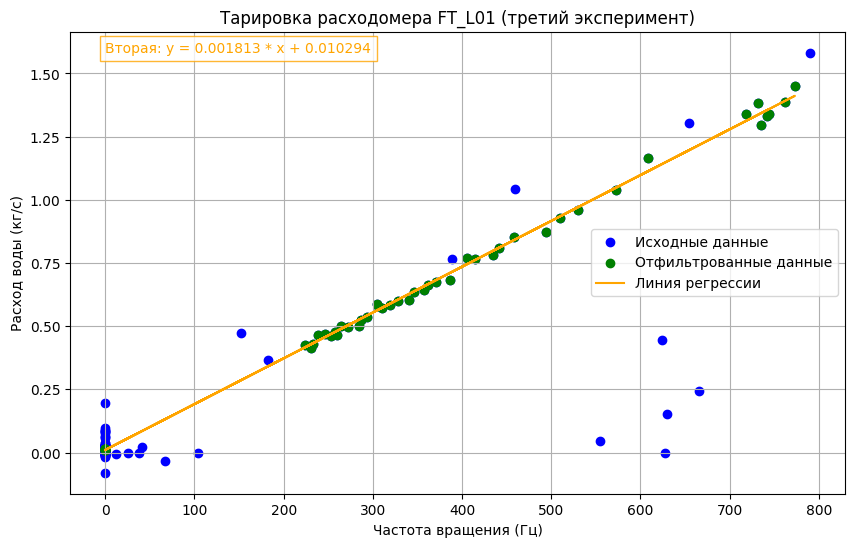

In [24]:
# Аналогичный код для третьего эксперимента
fig, ax = plt.subplots(figsize=(10, 6))

# Исходные данные
ax.scatter(merged_03['FT_L01_Hz_avg'], merged_03['flow_rate_kg_per_s'], color='blue', label='Исходные данные')

# Отфильтрованные данные
ax.scatter(filtered_03['FT_L01_Hz_avg'], filtered_03['flow_rate_kg_per_s'], color='green', label='Отфильтрованные данные')

# Вторая линия регрессии
ax.plot(filtered_03['FT_L01_Hz_avg'], model_03_filtered.predict(filtered_03['FT_L01_Hz_avg'].values.reshape(-1, 1)),
        color='orange', label='Линия регрессии')

# Добавление уравнений на график
x_range = (min(merged_03['FT_L01_Hz_avg']), max(merged_03['flow_rate_kg_per_s']))
eq4 = add_regression_equation(ax, model_03_filtered, x_range, color='orange', label_prefix='Вторая: ')

# Настройка графика
ax.set_xlabel('Частота вращения (Гц)')
ax.set_ylabel('Расход воды (кг/с)')
ax.set_title('Тарировка расходомера FT_L01 (третий эксперимент)')
ax.legend()
ax.grid()
plt.savefig(f'./results/fig/calibration_FT_L01_avg_03.png')
# Вывод графика
plt.show()

In [25]:
slope = model_03_filtered.coef_[0]
intercept = model_03_filtered.intercept_
print(f"Тарировка расходомера FT_L01 (третий эксперимент) y = {slope} * x + {intercept}")

Тарировка расходомера FT_L01 (третий эксперимент) y = 0.0018125490701920652 * x + 0.010293779162660499
